inputs: best_model/

contents: evaluating the model

In [2]:
import mlflow
pipeline = mlflow.sklearn.load_model("best_model")

In [3]:
pipeline

Pipeline(steps=[('selector',
                 DataFrameSelector(attribute_names=Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object'))),
                ('preprocessor', DataPreprocessor()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              col...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [4]:
import pandas as pd
test_df = pd.read_csv("data/test_df.csv")

In [5]:
predictions = pipeline.predict(test_df)

In [6]:
import yaml
with open('data/heart_disease_metadata.yaml', 'r') as f:
    metadata = yaml.safe_load(f)

In [7]:
import shap
# analyze the predictions using shap
model = pipeline.named_steps['regressor']

# Extract the preprocessing steps from the pipeline
# Assuming 'classifier' is the last step in the pipeline
preprocessing_pipeline = pipeline[:-1]  # Exclude the last step (classifier)

# Transform the input data using the preprocessing steps
preprocessed_input = preprocessing_pipeline.transform(test_df)


feature_names = test_df.columns
feature_titles = [metadata[col]['title'] if col in metadata and 'title' in metadata[col] else col for col in feature_names]
explainer = shap.TreeExplainer(model)
shap_values = explainer(preprocessed_input)


/Users/uberj/miniconda/envs/hd_cursor/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [8]:
shap_values

.values =
array([[-8.49624574e-02,  1.65933985e-02, -1.75254092e-01, ...,
         1.06093608e-01,  2.06139628e-02, -1.86508924e-01],
       [-7.41567463e-02, -7.08824843e-02, -1.12192720e-01, ...,
        -5.96532896e-02, -2.89452486e-02, -9.64957923e-02],
       [ 4.53946501e-01, -4.38873599e-07,  5.14431596e-02, ...,
        -4.45941016e-02,  2.60482393e-02, -8.40424374e-02],
       ...,
       [ 5.90018136e-03,  5.44826053e-02, -1.44860819e-01, ...,
        -1.56786181e-02, -2.72943199e-01, -1.31857216e-01],
       [-1.02137282e-01,  2.69066989e-02, -8.68760794e-02, ...,
        -7.22017810e-02, -1.36828851e-02, -7.12547600e-02],
       [-2.45315179e-01,  9.21363849e-03,  1.04035601e-01, ...,
        -1.10688575e-01, -2.49052078e-01,  4.31176543e-01]], dtype=float32)

.base_values =
array([0.99453497, 0.99453497, 0.99453497, 0.99453497, 0.99453497,
       0.99453497, 0.99453497, 0.99453497, 0.99453497, 0.99453497,
       0.99453497, 0.99453497, 0.99453497, 0.99453497, 0.99453497,
 

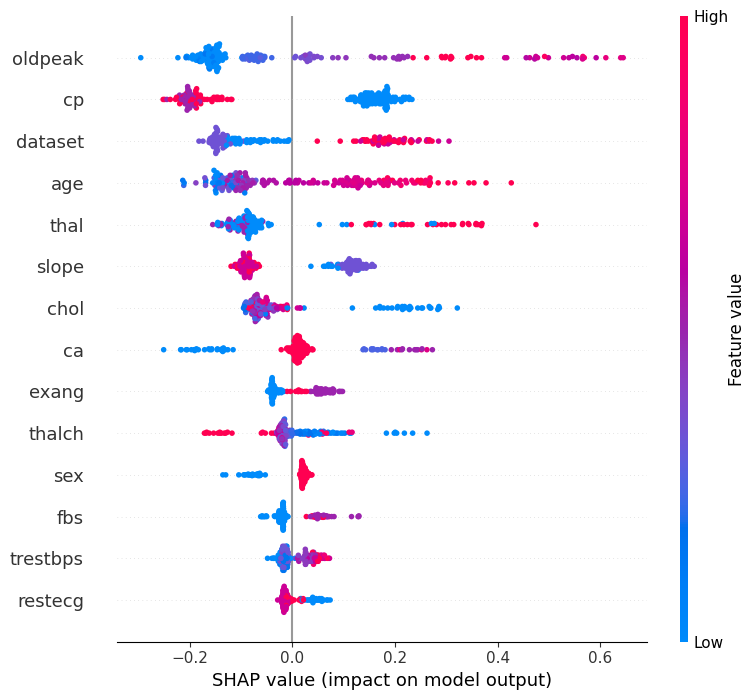

In [64]:
shap.summary_plot(shap_values, preprocessed_input)

In [65]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :].values, preprocessed_input.iloc[:1000, :])

In [68]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate
import numpy as np

# clip the values in label to be between 0 and 4
predictions = predictions.clip(0, 4)
# round the values in label to the nearest integer
predictions = np.round(predictions)

# Calculate overall regression metrics
metrics = {
    'Mean Squared Error': mean_squared_error(test_df['label'], predictions),
    'Mean Absolute Error': mean_absolute_error(test_df['label'], predictions),
    'R² Score': r2_score(test_df['label'], predictions)
}

# Print overall metrics table
print("Overall Regression Metrics:")
metrics_table = [[metric, f"{value:.3f}"] for metric, value in metrics.items()]
print(tabulate(metrics_table, headers=['Metric', 'Value'], tablefmt='grid'))

# Analysis by class
print("\nMetrics by Class:")
class_metrics = []
for class_num in range(5):  # 0-4 classes
    mask = (test_df['label'] == class_num)
    if mask.any():
        class_mse = mean_squared_error(test_df['label'][mask], predictions[mask])
        class_mae = mean_absolute_error(test_df['label'][mask], predictions[mask])
        class_count = mask.sum()
        avg_prediction = np.mean(predictions[mask])
        
        class_metrics.append([
            class_num,
            class_count,
            f"{class_mse:.3f}",
            f"{class_mae:.3f}",
            f"{avg_prediction:.2f}"
        ])

print(tabulate(class_metrics, 
              headers=['Class', 'Count', 'MSE', 'MAE', 'Avg Prediction'],
              tablefmt='grid'))

# Calculate confusion matrix metrics
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
conf_matrix = confusion_matrix(test_df['label'], predictions)

# Print confusion matrix in ASCII format
print("\nConfusion Matrix:")
print("Predicted →")
print("Actual ↓")
header = "    " + "   ".join(str(i) for i in range(5))
print(header)
for i, row in enumerate(conf_matrix):
    print(f"{i}   " + "   ".join(f"{cell:2d}" for cell in row))

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_df['label'], predictions, 
                          target_names=[f"Class {i}" for i in range(5)],
                          digits=3))

# Calculate per-class precision and recall
class_stats = []
for class_num in range(5):
    true_pos = conf_matrix[class_num, class_num]
    false_pos = conf_matrix[:, class_num].sum() - true_pos
    false_neg = conf_matrix[class_num, :].sum() - true_pos
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    
    class_stats.append([
        class_num,
        f"{precision:.3f}",
        f"{recall:.3f}"
    ])

print("\nPer-class Precision and Recall:")
print(tabulate(class_stats,
              headers=['Class', 'Precision', 'Recall'],
              tablefmt='grid'))



Overall Regression Metrics:
+---------------------+---------+
| Metric              |   Value |
+=====================+=========+
| Mean Squared Error  |   0.766 |
+---------------------+---------+
| Mean Absolute Error |   0.538 |
+---------------------+---------+
| R² Score            |   0.417 |
+---------------------+---------+

Metrics by Class:
+---------+---------+-------+-------+------------------+
|   Class |   Count |   MSE |   MAE |   Avg Prediction |
+=========+=========+=======+=======+==================+
|       0 |      82 | 0.451 | 0.354 |             0.35 |
+---------+---------+-------+-------+------------------+
|       1 |      53 | 0.396 | 0.358 |             1.17 |
+---------+---------+-------+-------+------------------+
|       2 |      22 | 0.409 | 0.409 |             1.77 |
+---------+---------+-------+-------+------------------+
|       3 |      21 | 2.143 | 1.381 |             1.62 |
+---------+---------+-------+-------+------------------+
|       4 |       6 

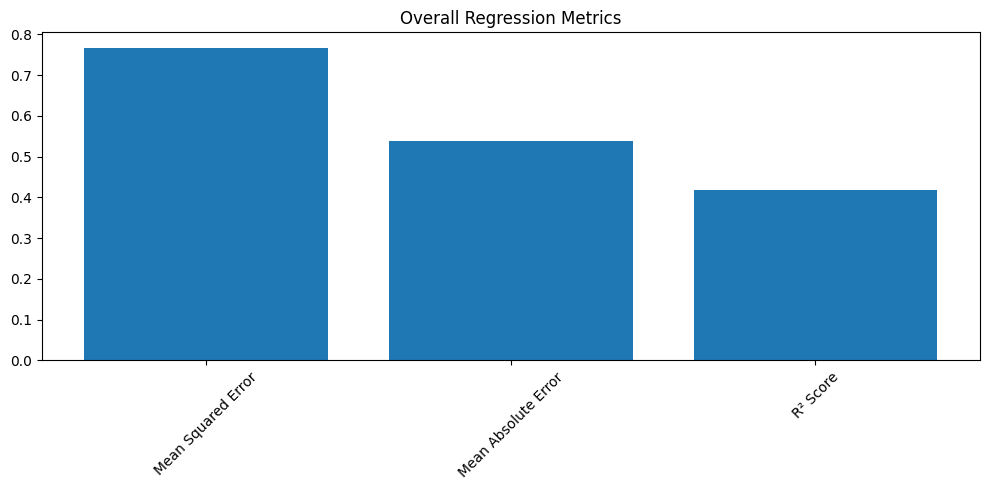

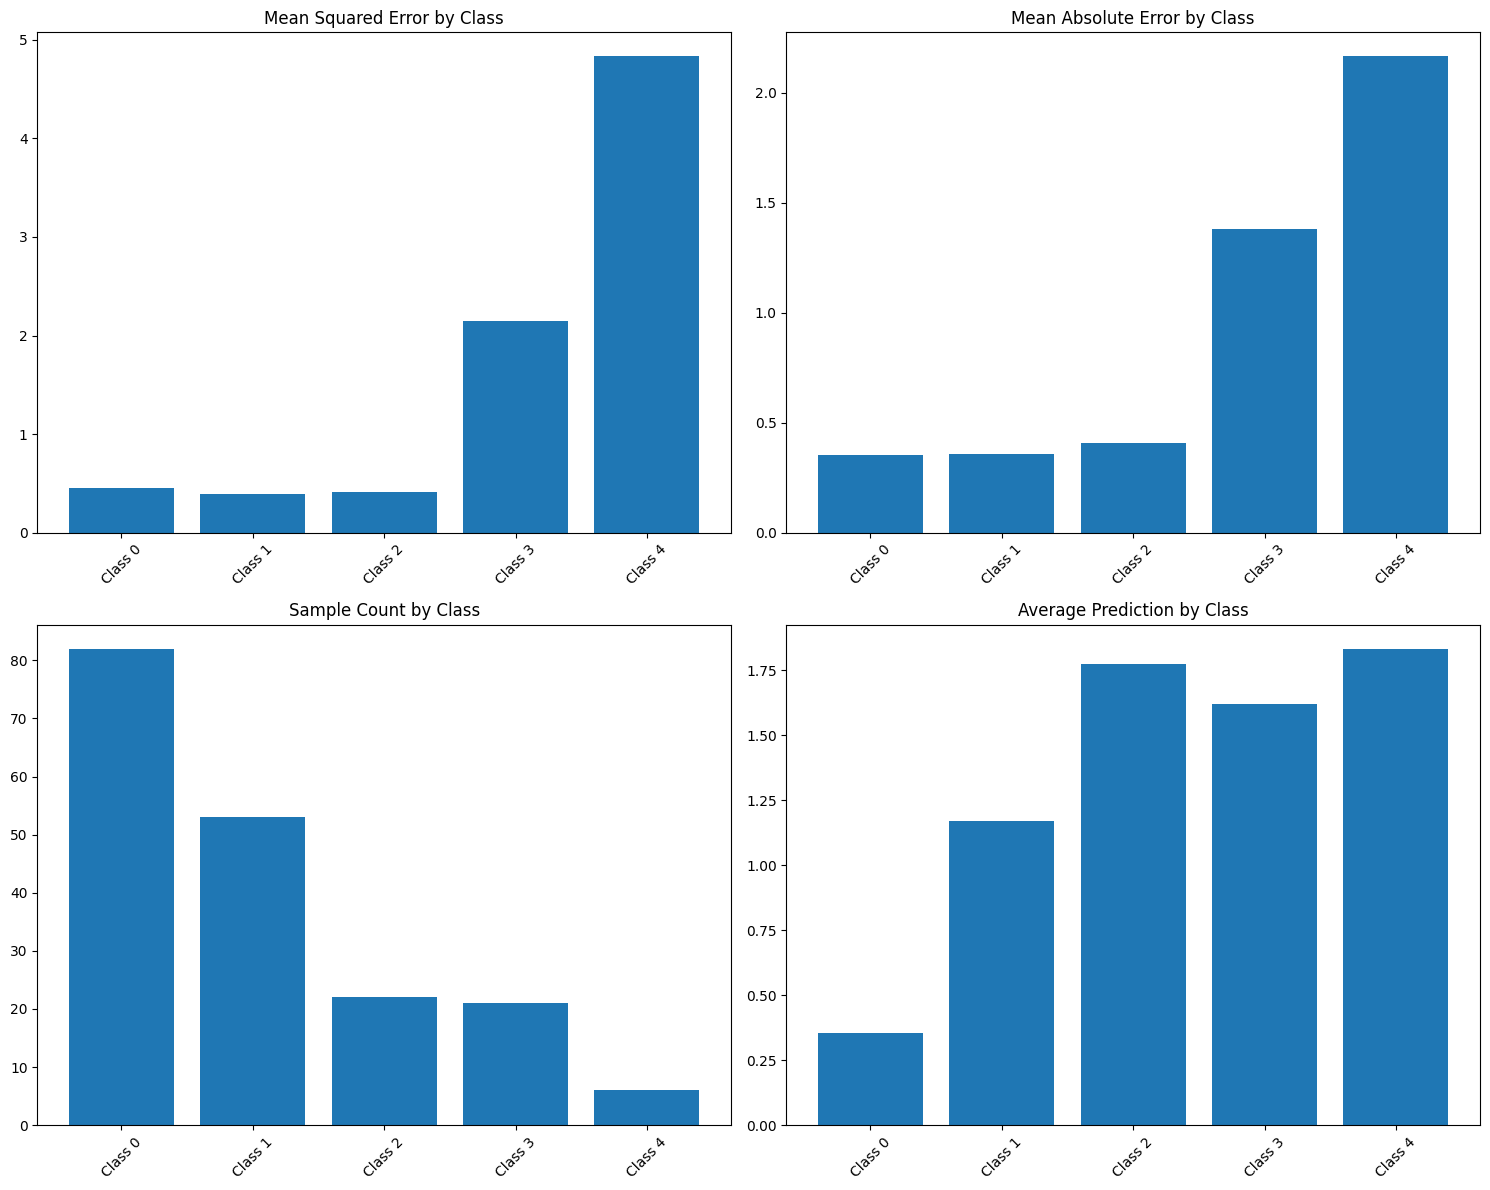

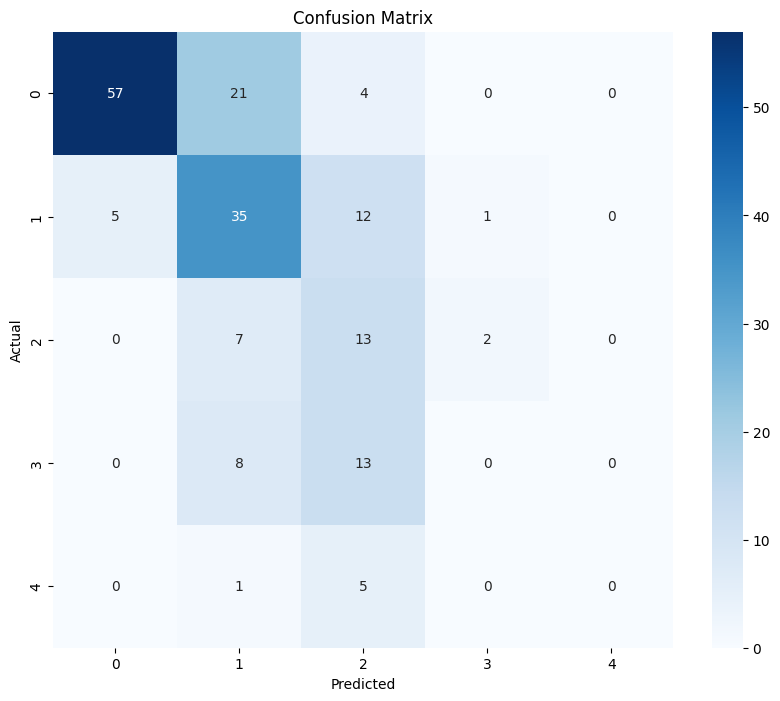

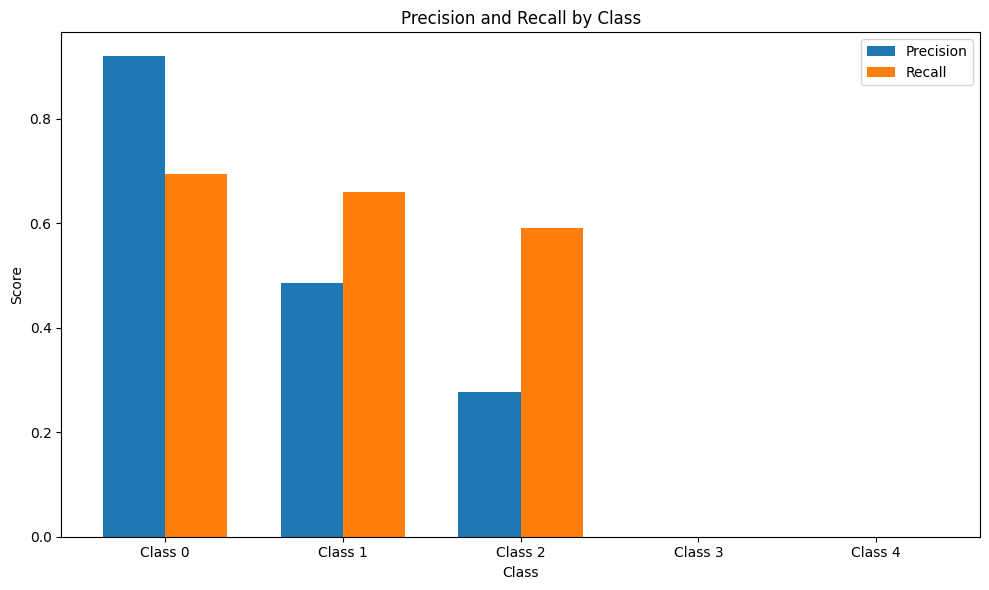

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate overall regression metrics
metrics = {
    'Mean Squared Error': mean_squared_error(test_df['label'], predictions),
    'Mean Absolute Error': mean_absolute_error(test_df['label'], predictions),
    'R² Score': r2_score(test_df['label'], predictions)
}

# Create a bar plot for overall metrics
plt.figure(figsize=(10, 5))
plt.bar(metrics.keys(), metrics.values())
plt.title('Overall Regression Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analysis by class
class_metrics_dict = {}
for class_num in range(5):  # 0-4 classes
    mask = (test_df['label'] == class_num)
    if mask.any():
        class_metrics_dict[f'Class {class_num}'] = {
            'MSE': mean_squared_error(test_df['label'][mask], predictions[mask]),
            'MAE': mean_absolute_error(test_df['label'][mask], predictions[mask]),
            'Count': mask.sum(),
            'Avg Prediction': np.mean(predictions[mask])
        }

# Create subplots for class-wise metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot MSE by class
classes = list(class_metrics_dict.keys())
mse_values = [metrics['MSE'] for metrics in class_metrics_dict.values()]
ax1.bar(classes, mse_values)
ax1.set_title('Mean Squared Error by Class')
ax1.set_xticklabels(classes, rotation=45)

# Plot MAE by class
mae_values = [metrics['MAE'] for metrics in class_metrics_dict.values()]
ax2.bar(classes, mae_values)
ax2.set_title('Mean Absolute Error by Class')
ax2.set_xticklabels(classes, rotation=45)

# Plot sample count by class
count_values = [metrics['Count'] for metrics in class_metrics_dict.values()]
ax3.bar(classes, count_values)
ax3.set_title('Sample Count by Class')
ax3.set_xticklabels(classes, rotation=45)

# Plot average predictions by class
avg_pred_values = [metrics['Avg Prediction'] for metrics in class_metrics_dict.values()]
ax4.bar(classes, avg_pred_values)
ax4.set_title('Average Prediction by Class')
ax4.set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_df['label'], predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate and plot precision and recall
class_stats = []
precisions = []
recalls = []
for class_num in range(5):
    true_pos = conf_matrix[class_num, class_num]
    false_pos = conf_matrix[:, class_num].sum() - true_pos
    false_neg = conf_matrix[class_num, :].sum() - true_pos
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall
plt.figure(figsize=(10, 6))
x = np.arange(5)
width = 0.35

plt.bar(x - width/2, precisions, width, label='Precision')
plt.bar(x + width/2, recalls, width, label='Recall')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall by Class')
plt.xticks(x, [f'Class {i}' for i in range(5)])
plt.legend()
plt.tight_layout()
plt.show()
